In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import numpy as np
base = '/home2/ebrahim/beyond-brainscore/'
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import sys
sys.path.append('/home2/ebrahim/beyond-brainscore/')
from plotting_functions import plot_across_subjects, plot_test_perf_across_layers, save_fMRI_simple, pass_info_plot_hist2d, find_rows_without_nan
from trained_results_funcs import create_pd_selected_models, find_best, max_across_selected_models
from trained_untrained_results_funcs import max_across_nested
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd
import matplotlib
from scipy.stats import ttest_rel, ttest_1samp
import nibabel as nib
from nilearn import plotting
from nilearn import surface
from nilearn import datasets
import plotly
import brainio

In [98]:
def find_best_sigma(sigma_range, noL2, exp, br_labels, resultsPath, dataset, perf='pearson_r'):
    
    if noL2:
        noL2_str = '_noL2_'
    else:
        noL2_str = '_'
        
    lang_indices = np.argwhere(br_labels[exp]=='language')
        
    sigma_perf_dict = {}
    
    for s in sigma_range:
        
        s = round(s,3)
        OASM_perf =  np.load(f'{resultsPath}/{dataset}_OASM-all-sigma_{s}_1{noL2_str}{exp}.npz')[perf]
        perf_lang = np.nanmedian(OASM_perf[lang_indices])
        
        if ~np.isnan(perf_lang):
            sigma_perf_dict[s] = perf_lang
        
    best_sigma = max(sigma_perf_dict, key=sigma_perf_dict.get)
    
    print(best_sigma)
    
    OASM_perf_best =  np.load(f'{resultsPath}/{dataset}_OASM-all-sigma_{best_sigma}_1{noL2_str}{exp}.npz')[perf]
        
    return sigma_perf_dict, best_sigma, OASM_perf_best

def find_best_layer(model, layer_range, noL2, exp, br_labels, resultsPath, dataset, perf='pearson_r'):
    
    if noL2:
        noL2_str = '_noL2_'
    else:
        noL2_str = '_'
        
    lang_indices = np.argwhere(br_labels[exp]=='language')
        
    layer_perf_dict = {}
    
    for l in layer_range:
    
        layer_perf =  np.load(f'{resultsPath}/{dataset}_gpt2-xl_layer_{l}_1{noL2_str}{exp}.npz')[perf]
        perf_lang = np.nanmedian(layer_perf[lang_indices])
        
        if ~np.isnan(perf_lang):
            layer_perf_dict[l] = perf_lang
        
    best_layer = max(layer_perf_dict, key=layer_perf_dict.get)
    
    layer_perf_best =  np.load(f'{resultsPath}/{dataset}_gpt2-xl_layer_{best_layer}_1{noL2_str}{exp}.npz')[perf]
        
    return layer_perf_dict, best_layer, layer_perf_best
        

In [99]:
noL2 = True
shuffled = True
dataset = 'fedorenko'

In [100]:
resultsPath_dataset_nonshuffled = f'/data/LLMs/brainscore/results_{dataset}'
if shuffled:
    resultsPath_dataset = f'/data/LLMs/brainscore/results_{dataset}/shuffled'
else:
    resultsPath_dataset = resultsPath_dataset_nonshuffled
data_processed_folder = f'/data/LLMs/data_processed/{dataset}/dataset'
figurePath = '/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/figures/new_figures/figure1/'
default_palette = sns.color_palette('deep')

In [101]:
# load information regarding number of voxels, subjects, and functional network localization for each experiment into a dictionary
exp = ['243', '384']
if dataset == 'pereira':
    exp = ['_243', '_384']
else:
    exp = ['']
    
br_labels_dict = {}
num_vox_dict = {}
ytest_dict = {}
mse_intercept_dict = {}
subjects_dict = {}
for e in exp:
    bre = np.load(f'{data_processed_folder}/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    mse_intercept_dict[e] = np.load(f'{resultsPath_dataset_nonshuffled}/mse_intercept{e}.npy')
    ytest_dict[e] = np.load(f'{resultsPath_dataset_nonshuffled}/y_test_ordered{e}.npy')
    subjects_dict[e] = np.load(f"{data_processed_folder}/subjects{e}.npy", allow_pickle=True)
    
num_vox_384 = br_labels_dict['384'].shape[0]
num_vox_243 = br_labels_dict['243'].shape[0]

FileNotFoundError: [Errno 2] No such file or directory: '/data/LLMs/data_processed/fedorenko/dataset/networks_243.npy'

In [85]:
sigma_values = np.linspace(0.1, 4.8, 48)

In [86]:
sigma_perf_dict_384, best_sigma_384, OASM_perf_best_sigma_384 = find_best_sigma(sigma_values, noL2=noL2, exp='384',
                                                resultsPath=resultsPath_pereira, br_labels=br_labels_dict)   
sigma_perf_dict_243, best_sigma_243, OASM_perf_best_sigma_243 = find_best_sigma(sigma_values, noL2=noL2, exp='243',
                                                resultsPath=resultsPath_pereira, br_labels=br_labels_dict)

0.3
0.3


Text(0, 0.5, 'Median pearson r across language voxels')

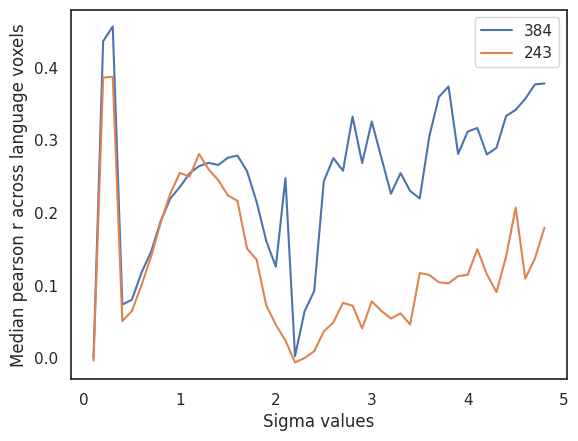

In [87]:
plt.plot(sigma_perf_dict_384.keys(), sigma_perf_dict_384.values(), label='384')
plt.plot(sigma_perf_dict_243.keys(), sigma_perf_dict_243.values(), label='243')
plt.legend()
plt.xlabel("Sigma values")
plt.ylabel("Median pearson r across language voxels")

In [88]:
gpt2_xl_384_dict, gpt2_xl_384_bl, gpt2_xl_384_bl_perf = find_best_layer('gpt2-xl', np.arange(0,49), noL2=noL2, exp='384', 
                                                   resultsPath=resultsPath_pereira, br_labels=br_labels_dict)
gpt2_xl_243_dict, gpt2_xl_243_bl, gpt2_xl_243_bl_perf = find_best_layer('gpt2-xl', np.arange(0,49), noL2=noL2, exp='243', 
                                                   resultsPath=resultsPath_pereira, br_labels=br_labels_dict)

Text(0, 0.5, 'Median pearson r across language voxels')

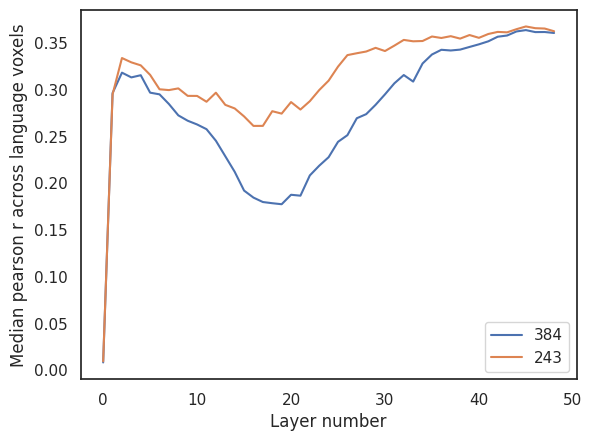

In [89]:
plt.plot(gpt2_xl_384_dict.keys(), gpt2_xl_384_dict.values(), label='384')
plt.plot(gpt2_xl_243_dict.keys(), gpt2_xl_243_dict.values(), label='243')
plt.legend()
plt.xlabel("Layer number")
plt.ylabel("Median pearson r across language voxels")

In [90]:
results_dict_OASM_384 = pd.DataFrame({'perf': OASM_perf_best_sigma_384, 'subjects': subjects_dict['384'], 
                'Network': br_labels_dict['384'], 'Model': np.repeat('OASM', num_vox_384)})
results_dict_OASM_243 = pd.DataFrame({'perf': OASM_perf_best_sigma_243, 'subjects': subjects_dict['243'], 
                'Network': br_labels_dict['243'], 'Model': np.repeat('OASM', num_vox_243)})
results_dict_gpt2_384 = pd.DataFrame({'perf': gpt2_xl_384_bl_perf, 'subjects': subjects_dict['384'], 
                'Network': br_labels_dict['384'], 'Model': np.repeat('gpt2-xl', num_vox_384)})
results_dict_gpt2_243 = pd.DataFrame({'perf': gpt2_xl_243_bl_perf, 'subjects': subjects_dict['243'], 
                'Network': br_labels_dict['243'], 'Model': np.repeat('gpt2-xl', num_vox_243)})

results_OASM_gpt2xl_243 = pd.concat((results_dict_OASM_243, results_dict_gpt2_243))
results_OASM_gpt2xl_384 = pd.concat((results_dict_OASM_384, results_dict_gpt2_384))

In [91]:
results_OASM_gpt2xl_384.head()

,perf,subjects,Network,Model
0,0.472767,018,language,OASM
1,0.433400,018,language,OASM
2,0.431842,018,language,OASM
3,0.431253,018,language,OASM
4,0.439932,018,language,OASM


Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

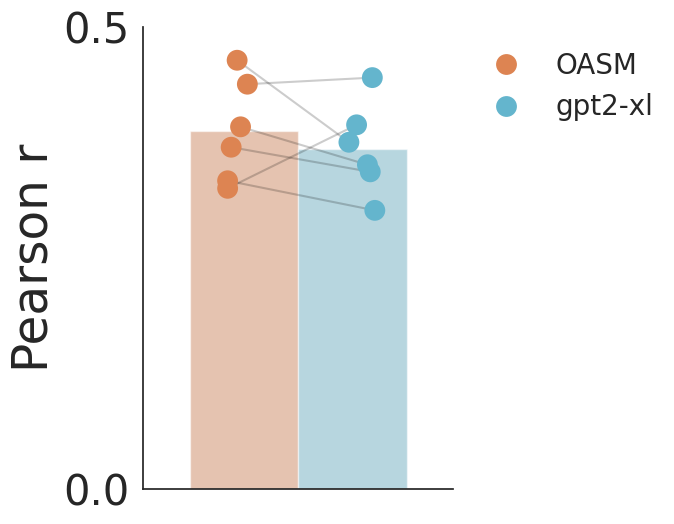

In [92]:
_, _, _ = plot_across_subjects(results_OASM_gpt2xl_243.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName=f'pereira_noL2_shufffled_384', 
                                             yticks=[0,0.5], order=['language'], clip_zero=False, color_palette=[default_palette[1], default_palette[9]], 
                                             draw_lines=True, ms=15, plot_legend=True, 
                                             plot_legend_under=False, width=0.7, median=True, ylabel_str='Pearson r')

Taking median value across voxels with a participant


<Figure size 640x480 with 0 Axes>

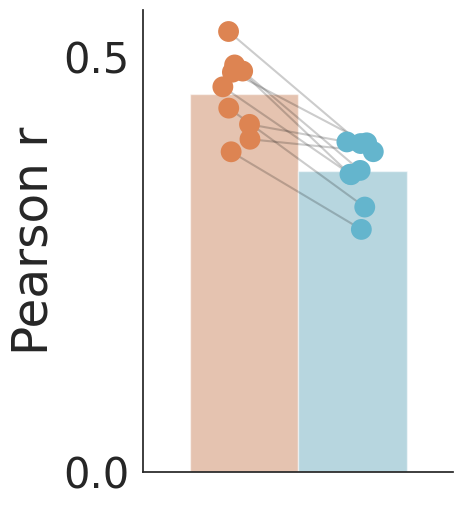

In [93]:
_, _, _ = plot_across_subjects(results_OASM_gpt2xl_384.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName=f'pereira_noL2_shufffled_243', 
                                             yticks=[0,0.5], order=['language'], clip_zero=False, color_palette=[default_palette[1], default_palette[9]], 
                                             draw_lines=True, ms=15, plot_legend=False, 
                                             plot_legend_under=False, width=0.7, median=True, ylabel_str='Pearson r')